## Introduction

If there are few (typically 2) ways of using the word in a sentence and only one of them is correct, we call it an _alternative problem_, and the word we call _problematic word_. The typical example in English language is whether to write the ending -s to the verb: "I see", but "she sees". In Russian, these alternative problems are much more present and deserve their own codebase.

The approach is to take the correct sentences, replace the problematic words with their counterparts, thus building negative samples. Also, when doing it, we want to balance the sentences by corpus and by length, as these factors often affect the performance. Finally, when we merge the data from different corpora, we want to update `sentence_id`, `word_id` and `paragraph_id`, as those must be unique in the dataset.


## TSA 

TSA is an alternative problem where verbs have similar but different endings in invinitive (ться) and finite form (тся). No all the verbs are like this (e.g. нравится/нравиться, but хочется/хотеться), so first we need to filter the verbs that are _problematic_.

### Creating dictionary


First, let's define the list of corpora we will use in our bundle. Assume we have three corpora: news, publicistics and books.

In [17]:
from tg.grammar_ru import Loc

corpora = [
    Loc.corpus_path/'books.base.zip',
    Loc.corpus_path/'pub.base.zip',
    #Loc.corpus_path/'lenta.base.zip',
]

In [23]:
from tg.projects.alternative import DictionaryFilterer
from tg.grammar_ru.corpus import BucketBalancer, CorpusReader
from pathlib import Path
from yo_fluq_ds import *

good_words = set(FileIO.read_json('files/tsa-dict.json'))
buckets_path = Path('files/tsa-buckets.parquet')


tsa_filter = DictionaryFilterer(good_words)
if not buckets_path.is_file():
    en = CorpusReader.read_frames_from_several_corpora(corpora).feed(fluq.with_progress_bar()).select(tsa_filter.filter)
    buckets_df = BucketBalancer.collect_buckets(en)
    buckets_df.to_parquet(buckets_path)
else:
    buckets_df = pd.read_parquet(buckets_path)


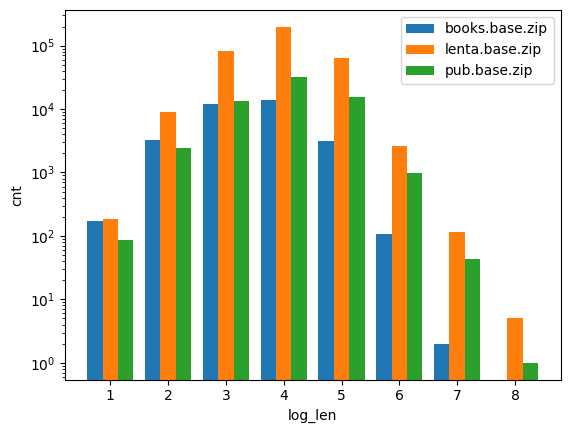

In [24]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.set_yscale('log')
ax.legend()


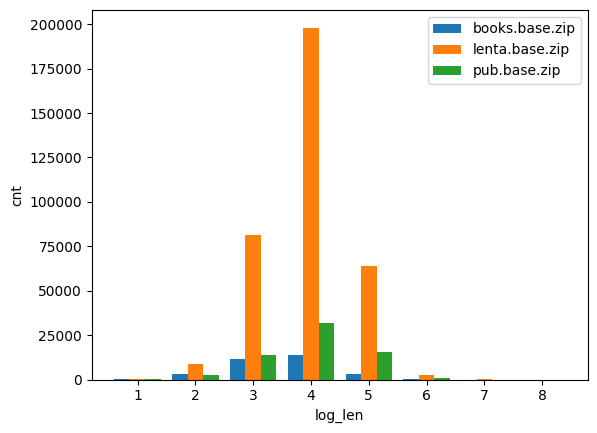

In [25]:
import numpy as np
take_df = buckets_df
take_df['random'] = np.random.rand(take_df.shape[0])
take_df = take_df.feed(fluq.add_ordering_column(['corpus_id','log_len'],'random'))
#take_df = take_df.loc[take_df.order<5000]


ax = grbar_plot(
    take_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()


Let's convert `take_df` into simpler format for `BucketBalancer`, and create a balancer:

In [26]:
tsa_balancer = BucketBalancer(BucketBalancer.buckets_statistics_to_dict(take_df))
str(tsa_balancer.buckets)[:100]

"{'books.base.zip': {9699332, 19660807, 19660812, 9699348, 30933015, 26214426, 13369370, 16252957, 13"

At this point, we are ready to perform transfusion. Transfusion is an operation that reads the corpora, samples the sentences and creates a new corpus with these selected sentences. Along the way it also correct all the ids, thus making sure the merged corpus is consistant.


In [27]:
from tg.projects.alternative import AlternativeTaskTransfuseSelector, EndingNegativeSampler
from tg.grammar_ru.corpus import CorpusBuilder
from tg.common import Logger

Logger.disable()

tsa_sampler = EndingNegativeSampler('тся','ться')

selector = AlternativeTaskTransfuseSelector(
    tsa_balancer,
    tsa_filter,
    tsa_sampler
)

tsa_transfused = Loc.temp_path/'demos/bundle/tsa.transfused.zip'

CorpusBuilder.transfuse_corpus(
    sources = corpora,
    destination = tsa_transfused,
    selector = selector,
    words_per_frame = 3000,
    # words_limit=20000,
    overwrite = True
)

In [28]:
from tg.grammar_ru import CorpusReader

CorpusReader(tsa_transfused).get_toc()

,filename,timestamp,part_index,token_count,character_count,ordinal,max_id
file_id,,,,,,,
2ba1f1fb-bbc0-4f2d-9738-9abf440da2ab,,2023-12-30 18:09:15,0,2984,14002,0,3084
96beb083-3461-4eed-9eea-17b386555b0f,,2023-12-30 18:09:15,1,2989,12961,1,6194
2874b013-e50d-4397-8b54-47c86b9356d5,,2023-12-30 18:09:15,2,2971,12936,2,9297
37dbfb24-a18b-41ad-8a95-d4cb482df54b,,2023-12-30 18:09:15,3,2987,13314,3,12405
40c38bd3-22ad-4394-95d3-80b52575856b,,2023-12-30 18:09:15,4,2987,13538,4,15480
...,...,...,...,...,...,...,...
f6a3c0ed-69c5-4835-aaea-754d96b8496a,,2023-12-30 21:15:58,1515,2991,15558,1515,5275187
8244c5b4-58f7-416e-bf87-4b37de881401,,2023-12-30 21:15:58,1516,2991,14913,1516,5278585
e776e991-721e-4dbf-8e59-5832697da288,,2023-12-30 21:15:59,1517,2869,14526,1517,5281784


In [29]:
CorpusReader(tsa_transfused).get_frames().first().head()

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,original_word_id,original_sentence_id,original_paragraph_id,updated,file_id,corpus_id,is_target,label,original_corpus
0,0,0,0,0,1,Чем,ru,3,10784,10716,10711,False,2ba1f1fb-bbc0-4f2d-9738-9abf440da2ab,tsa.transfused.zip,False,0,books.base.zip
1,1,0,1,0,1,больше,ru,6,10785,10716,10711,False,2ba1f1fb-bbc0-4f2d-9738-9abf440da2ab,tsa.transfused.zip,False,0,books.base.zip
2,2,0,2,0,1,он,ru,2,10786,10716,10711,False,2ba1f1fb-bbc0-4f2d-9738-9abf440da2ab,tsa.transfused.zip,False,0,books.base.zip
3,3,0,3,0,1,старался,ru,8,10787,10716,10711,False,2ba1f1fb-bbc0-4f2d-9738-9abf440da2ab,tsa.transfused.zip,False,0,books.base.zip
4,4,0,4,0,1,сосредоточиться,ru,15,10788,10716,10711,False,2ba1f1fb-bbc0-4f2d-9738-9abf440da2ab,tsa.transfused.zip,True,0,books.base.zip


The next step is to enrich the corpus with features. This can also be done with `CorpusBuilder`:

In [30]:
from tg.grammar_ru.features import PyMorphyFeaturizer, SlovnetFeaturizer, SnowballFeaturizer

tsa_featurized = Loc.temp_path/'demos/bundle/tsa.featurized.zip'

CorpusBuilder.featurize_corpus(
    tsa_transfused,
    tsa_featurized,
    [SnowballFeaturizer()]
)

Now we have all the information in the corpus format. We need to assemble this in bundle format: concatenate all the separate frames from `src`, `pymorphy` and other frames:

In [31]:
tsa_bundle = Loc.temp_path/'demos/bundle/tsa_bundle'
CorpusBuilder.assemble(
    tsa_featurized,
    tsa_bundle
)

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

And finally, we need to create an index frame. This is usually just a subset of `src` frame:

In [32]:
from tg.common.ml.batched_training import train_display_test_split

index_frame = pd.read_parquet(tsa_bundle/'src.parquet')
index_frame = index_frame.loc[index_frame.is_target][['word_id','sentence_id','label']].reset_index(drop=True)
index_frame.index.name = 'sample_id'
index_frame['split'] = train_display_test_split(index_frame)
index_frame.to_parquet(tsa_bundle/'index.parquet')
index_frame.head()

,word_id,sentence_id,label,split
sample_id,,,,
0,4,0,0,display
1,38,1,0,test
2,49,2,0,test
3,55,3,0,train
4,62,4,0,train


In [33]:
from tg.common import DataBundle

db = DataBundle.load(tsa_bundle)
print('ok')

ok


In [ ]:
CorpusReader(tsa_bundle)

## CHTOBY task

CHTOBY is an alternative problem of "что бы" vs "чтобы". There is a technical problem when building negative samples, as the word count is different when one option is replaced by another. Therefore, other implementations of filterer and sampler are needed:

In [40]:
from tg.grammar_ru import Separator
from tg.projects.alternative import WordSequenceFilterer

df = Separator.separate_string('Что бы поделать, чтобы не скучать')
chtoby_filter = WordSequenceFilterer([['чтобы'], ['что','бы']])

chtoby_filter.filter(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Что,ru,3,True
1,1,0,1,0,1,бы,ru,2,False
2,2,0,2,0,0,поделать,ru,8,False
3,3,0,3,0,1,",",punct,1,False
4,4,0,4,0,1,чтобы,ru,5,True
5,5,0,5,0,1,не,ru,2,False
6,6,0,6,0,0,скучать,ru,7,False


In [18]:
from tg.projects.alternative import WordPairsNegativeSampler
df = Separator.separate_string('Что бы поделать, чтобы не скучать')
df = chtoby_filter.filter(df)

chtoby_sampler = WordPairsNegativeSampler([('чтобы', 'что бы'), ('Чтобы', 'Что бы')])

chtoby_sampler.build_negative_sample_from_positive(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Чтобы,ru,23,True
1,1,0,1,0,0,поделать,ru,8,False
2,2,0,2,0,1,",",punct,1,False
3,3,0,3,0,1,что,ru,21,True
4,4,0,4,0,1,бы,ru,2,False
5,5,0,5,0,1,не,ru,2,False
6,6,0,6,0,0,скучать,ru,7,False


In [19]:
pd.concat(chtoby_sampler.build_all_negative_samples_from_positive(df))

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Чтобы,ru,23,True
1,1,0,1,0,0,поделать,ru,8,False
2,2,0,2,0,1,",",punct,1,False
3,3,0,3,0,1,чтобы,ru,5,False
4,4,0,4,0,1,не,ru,2,False
5,5,0,5,0,0,скучать,ru,7,False
0,0,0,0,0,1,Что,ru,3,False
1,1,0,1,0,1,бы,ru,2,False
2,2,0,2,0,0,поделать,ru,8,False
3,3,0,3,0,1,",",punct,1,False
